# Calculate doublet scores for each cell using Scrublet

## Import statements

In [1]:
import scanpy as sc
import scanpy.external as sce
#sc.logging.print_versions()
#sc.logging.print_memory_usage()
#sc.settings.verbosity = 2
import os,sys
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as mticker

In [2]:
#import scrublet
import scrublet as scr

In [3]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("utility_functions"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import, import after scanpy to overwrite rc.Params
import rz_utility_spring as srz

python version: 3.8.8


# Load data

In [4]:
adata = sc.read_h5ad('backups/all_cells_w_dblts_batch_corrected_20021x3000_230928_15h56.h5ad') 
# overwrite obs with the most recent version
filename = 'backups/obs_info_technical_20021x8_230928_14h20.npz'
encoding = 'latin1'

with np.load(filename,encoding=encoding, allow_pickle = True) as f:
    obs = pd.DataFrame(**f)
adata.obs = obs


## Load details on the latest SPRING plot  
In general, this is not necessary to run Scrublet.  

In [5]:
# load intermediates I saved when preparing the SPRING plot
path1 = "/Users/karolisgoda/Library/CloudStorage/GoogleDrive-karolisgoda@gmail.com/My Drive/MF/data/SPRING_dev-master/data/" 
project_dir = path1+'CD34/'
plot_name =  'all_cells_w_dblts_spring'


params = rz.load_stuff(project_dir+plot_name+'/params.pickle')
params.keys()

dict_keys(['k', 'cell_mask', 'min_counts', 'min_cells', 'base_ix', 'num_pc', 'plot_name', 'embedding', 'gene_names_excluded', 'abundant_gene_mask', 'v_score_dict', 'nr_var_genes', 'genes_used', 'eigenvectors', 'eigenvalues', 'neighbors_fa', 'neighbors_umap', 'min_dist'])

In [6]:
# make sure the data is unnormalized, should sum to different total counts (and round numbers)
adata.raw.X[:5,:].sum(axis=1)

matrix([[22260.],
        [ 8560.],
        [19847.],
        [10175.],
        [ 7250.]], dtype=float32)

In [7]:
P = params['eigenvectors'][:params['num_pc'],:] #the P is the same for fa2 and umap representations
P.shape

(41, 3000)

In [8]:
bdata = adata.raw.to_adata() #it is not necessary here to create a new variable

In [9]:
bdata

AnnData object with n_obs × n_vars = 20021 × 37733
    obs: 'barcode', 'library', 'total_counts', 'pct_counts_mito', 'conditions', 'conditions2', 'preservation', 'method'
    uns: 'X_lin_cptt', 'X_log_z', 'conditions2_colors', 'conditions_colors', 'draw_graph', 'method_colors', 'neighbors', 'pca', 'preservation_colors', 'umap'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_pca_harmony', 'X_umap'

In [10]:

# prepare  variables to plug into scrublet
gene_mask = np.in1d(bdata.var_names,params['genes_used'])
cell_mask = params['cell_mask'].astype(bool)
n_counts = np.array(adata[cell_mask,:].raw.X.sum(axis=1).T)[0]

P = params['eigenvectors'][:params['num_pc'],:] #eigenvector
print(gene_mask.sum(),len(gene_mask))
print(cell_mask.sum(),len(cell_mask))
postnorm_total = 1e4

X = bdata[cell_mask].X
X_norm = sc.pp.normalize_per_cell(bdata[cell_mask],counts_per_cell_after=postnorm_total,copy=True).X
subobs = adata.obs[cell_mask]
X_norm.sum(axis=1)

3000 37733
20021 20021


matrix([[10000.   ],
        [10000.   ],
        [10000.001],
        ...,
        [10000.   ],
        [10000.001],
        [ 9999.999]], dtype=float32)

In [11]:
gene_means = X_norm[:,gene_mask].mean(0).A.squeeze()
gene_stdevs = np.sqrt(scr.sparse_var(X_norm[:, gene_mask]))

In [12]:
# double-check the shapes
print(P.shape,len(gene_means))

(41, 3000) 3000


## Calculate doublet scores

### Decide on which cells to treat collectively

In [13]:
# doublet can only be made of real cells present in the same cell suspension being injected into
# a scRNAseq device.
# therefore, it makes sense to run the doublet detector on each separate cell suspension (in other words,
# for each emulsion)
# also, the doublet rate can be different between samples.

splitby = 'conditions'
subobs[splitby].unique()

array(['10X fresh', 'InDrop2 fresh 1', 'InDrop2 fresh 2', '10X fixed',
       'InDrop2 fixed'], dtype=object)

In [14]:
subobs.groupby([splitby]).count().dropna().iloc[:,:1]

,barcode
conditions,
10X fixed,9185
10X fresh,3124
InDrop2 fixed,5463
InDrop2 fresh 1,1104
InDrop2 fresh 2,1145


### Run Scrubet on each emulsion separately  
By design, doublets cannot form between emulsions  

In [15]:
# I want to apply the same principal component transformation to all emulsions but allow
# simulated doublets only within the same emulsion

# This is 

scrub_dict = {}
doub_score_dict = {}
predict_doub_dict = {}

for emulsion in adata.obs[cell_mask][splitby].unique():
    cmask = (adata.obs[cell_mask][splitby] == emulsion).values
    
    print(emulsion)
    
    # select the expression data:
    E = X[cmask,:][:,gene_mask]
    
    # initiate the scrub object
    scrub = scr.Scrublet(E, total_counts=n_counts[cmask], expected_doublet_rate=0.06)
     
    # Simulate doublets
    scrub.simulate_doublets()
    
    # Total counts normalize
    scrub._E_obs_norm = scr.tot_counts_norm(scrub._E_obs, total_counts=n_counts[cmask], target_total=postnorm_total)
    scrub._E_sim_norm = scr.tot_counts_norm(scrub._E_sim, total_counts=scrub._total_counts_sim, target_total=postnorm_total)
    
    # Z-score using previously calculated gene means and standard deviations. Same way as for original spring plot.
    scrub._E_obs_norm = np.array(scr.sparse_zscore(scrub._E_obs_norm, gene_means, gene_stdevs))
    scrub._E_sim_norm = np.array(scr.sparse_zscore(scrub._E_sim_norm, gene_means, gene_stdevs))
    
    # Transform simulated doublets into same PCA space as the observed cells
    pca_obs = P.dot(scrub._E_obs_norm.T).T
    pca_sim = P.dot(scrub._E_sim_norm.T).T
    
    # Set the "manifold", i.e. the space in which the knn graph will be constructed
    scrub.set_manifold(pca_obs, pca_sim)
    
    # Calculate doublet scores and call doublets as usual
    doublet_scores = scrub.calculate_doublet_scores()
    predicted_doublets = scrub.call_doublets()
    
    # store results
    scrub_dict[emulsion] = scrub
    doub_score_dict[emulsion] = doublet_scores
    predict_doub_dict[emulsion] = predicted_doublets

10X fresh
Automatically set threshold at doublet score = 0.52
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 13.6%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 1.7%
InDrop2 fresh 1
Automatically set threshold at doublet score = 0.40
Detected doublet rate = 1.0%
Estimated detectable doublet fraction = 16.2%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 6.2%
InDrop2 fresh 2
Automatically set threshold at doublet score = 0.40
Detected doublet rate = 1.4%
Estimated detectable doublet fraction = 18.5%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 7.5%
10X fixed
Automatically set threshold at doublet score = 0.34
Detected doublet rate = 1.4%
Estimated detectable doublet fraction = 24.6%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 5.7%
InDrop2 fixed
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 2.7%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 8.2%


## Check doublet histograms

In [16]:
# print the automatically determined threshold:
for key,value in scrub_dict.items():
    print(key,value.threshold_)

10X fresh 0.5181815903159012
InDrop2 fresh 1 0.3988716165337025
InDrop2 fresh 2 0.39961725291566996
10X fixed 0.34291739361986295
InDrop2 fixed 0.5993051925476085


10X fresh 3124
predicted doublet percentage 0.22407170294494239


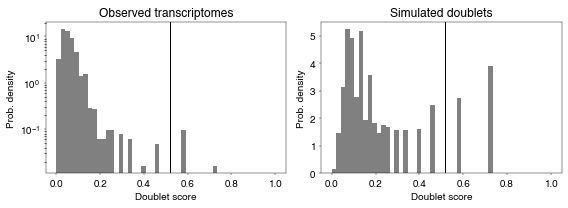


InDrop2 fresh 1 1104
predicted doublet percentage 0.9963768115942028


<Figure size 432x288 with 0 Axes>

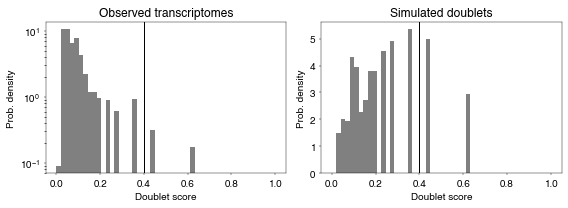


InDrop2 fresh 2 1145
predicted doublet percentage 1.3973799126637554


<Figure size 432x288 with 0 Axes>

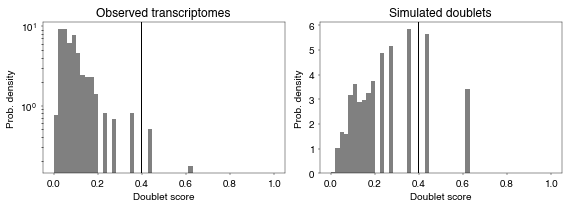


10X fixed 9185
predicted doublet percentage 1.3935764833968427


<Figure size 432x288 with 0 Axes>

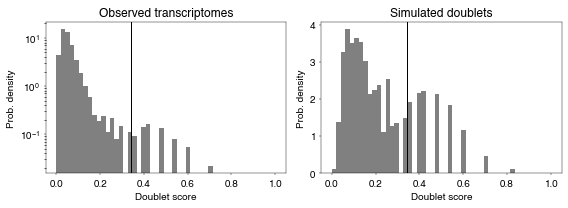


InDrop2 fixed 5463
predicted doublet percentage 0.21965952773201539


<Figure size 432x288 with 0 Axes>

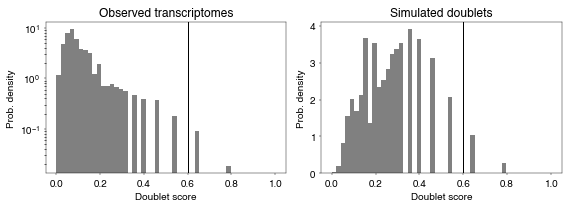

<Figure size 432x288 with 0 Axes>

In [17]:
for emulsion, scrub in scrub_dict.items():
    print(emulsion,(adata.obs[splitby] == emulsion).sum())
    dmask = predict_doub_dict[emulsion]
    print('predicted doublet percentage',dmask.sum()/len(dmask)*100.)
    scrub.plot_histogram();
    plt.show()
    plt.savefig('figures/%s_v0_doublet_scores_prec_pca.pdf'%emulsion)
    print()

## Add results to adata.obs

In [18]:
obs = adata.obs.copy()

# add the results to obs
obs['doublet_score'] = np.nan
obs['potential_doublet'] = np.nan

for key,value in doub_score_dict.items():
    cmask = (obs[splitby] == key).values
    
    obs.loc[cmask&cell_mask,'doublet_score'] = value
    obs.loc[cmask&cell_mask,'potential_doublet'] = predict_doub_dict[key]
    
    # also add another colortrack: within the x% with highest doublet score
    for i in [3,5,10]:   
        obs.loc[cmask&cell_mask,'top%dpct_dbtl_score'%i] = \
        obs.loc[cmask&cell_mask,'doublet_score']>=obs.loc[cmask,'doublet_score'].quantile(1.-float(i)/100.)

## Save obs only

In [23]:
# save the update obs dataframe
# no need to save the entire adata object, counts didn't change

fname = 'backups/obs_info_scrub_%dx%d_%s'%(obs.shape[0],obs.shape[1],rz.now())
print(fname)
rz.save_df(obs,fname)

backups/obs_info_scrub_20021x13_230928_16h03


/opt/anaconda3/envs/sc/lib/python3.8/site-packages/numpy/lib/format.py:362: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


## Optional: add colotrack to SPRING

In [24]:
# path was specified earlier

# select to append:
toappend = ['potential_doublet',
            'top3pct_dbtl_score','top5pct_dbtl_score','top10pct_dbtl_score']

toappend_cont = ['doublet_score']

# color dictionary
cdd = srz.read_cell_groupings(project_dir+plot_name+'/categorical_coloring_data.json')
cdd = {key:value['label_colors'] for key,value in cdd.items()}

# get cell filter:
cell_ix = np.loadtxt(project_dir+plot_name+'/cell_filter.txt',dtype=int)

# prepare cell groupings dictionary (discrete)
cg = obs.iloc[cell_ix][toappend].astype(str).to_dict(orient='list')

# prepare numerical
ctracks = obs[cell_mask][toappend_cont].fillna(0).astype(float).to_dict(orient='list')

# append categorical
srz.append_cell_groupings(project_dir+plot_name,cg,colordd=cdd)
# append numerical
srz.append_color_tracks(ctracks,project_dir+plot_name,backup=True)

In [25]:
plot_name = 'all_cells_w_dblts_spring' #adding to umap as well

In [26]:
# color dictionary
cdd = srz.read_cell_groupings(project_dir+plot_name+'/categorical_coloring_data.json')
cdd = {key:value['label_colors'] for key,value in cdd.items()}

# get cell filter:
cell_ix = np.loadtxt(project_dir+plot_name+'/cell_filter.txt',dtype=int)

# prepare cell groupings dictionary (discrete)
cg = obs.iloc[cell_ix][toappend].astype(str).to_dict(orient='list')

# prepare numerical
ctracks = obs[cell_mask][toappend_cont].fillna(0).astype(float).to_dict(orient='list')

# append categorical
srz.append_cell_groupings(project_dir+plot_name,cg,colordd=cdd)
# append numerical
srz.append_color_tracks(ctracks,project_dir+plot_name,backup=True)